In [1]:
######################################################################
# N.B. Requires python environment with packages installed and #
# This script requires hard coded links #
# #
# Loads Phylobayes formatted trees and analyzes node ages #
# #
# © MIT EAPS Fournier Lab Jack G. Payette E: payette@mit.edu #
# #
######################################################################

In [2]:
import ete3
import pandas as pd
import re
import multiprocessing
import itertools
import random
import collections
import operator
import os
from scipy import stats

In [3]:
import numpy as np
#import pymc3
import seaborn as sns
import arviz
from matplotlib import pyplot as plt
from matplotlib.ticker import(MultipleLocator,FormatStrFormatter,AutoMinorLocator)
# Data stored to disk using pickle
import pickle as pkl

In [4]:
#Example installation call -- you may need to use pip,pip3,conda,miniconda t
#
# ! pip install arviz
# returns: Requirement already satisfied: arviz in /home/payette/.conda/env
#
# module add engaging/anaconda/2.3.0
# conda env list
# conda activate py37
#

In [5]:
#################
# Function defs #
#################

In [6]:
def get_node_age_from_descendants(tree,descendants):
    node=tree.get_common_ancestor(descendants)
    return(node.support)

In [7]:
def get_ci_of_the_mean(data, confidence=0.95):
    degrees_of_freedom = len(data) - 1
    tailed_alpha = (1 - confidence) / 2
    t_stats      = stats.t.ppf(tailed_alpha, degrees_of_freedom)
    std_err      = np.std(data) / np.sqrt( degrees_of_freedom )
    data_mean    = np.mean(data)
    return(data_mean - abs(t_stats * std_err), data_mean + abs(t_stats * std_err))

In [8]:
#BASIC CODE BLOCK!!! **LOAD TREES*** New code to read each line
def LoadTrees(chronogram_filename):
    #os.chdir("/Users/payette/Dropbox (MIT)/Py-code-mit/Py-code-mit/modeldata/")
    posterior_trees = []
    for line in open(chronogram_filename).readlines():
        posterior_trees.append(ete3.Tree(line, format=0,quoted_node_names=False))
        #NOTE NODE.SUPPORT = NODE AGE ESTIMATE, NODE.DIST = BRANCH LENGTH
        #DEBUG: print(line)
    return(posterior_trees)
#Dec-19-2019
def LoadTrees1(chronogram_filename):
    #os.chdir("/Users/payette/Dropbox (MIT)/Py-code-mit/Py-code-mit/modeldata/")
    posterior_trees = []
    for line in open(chronogram_filename).readlines():
        posterior_trees.append(ete3.Tree(line, format=1,quoted_node_names=False)) #for single chronogram format
        #NOTE NODE.SUPPORT = NODE AGE ESTIMATE, NODE.DIST = BRANCH LENGTH
        #DEBUG: print(line)
    return(posterior_trees)

In [9]:
# Start initializing routine and tree diagnostics
# Load guide tree & label tree
# N.B. guide Tree is not in use in this script.
# ASSUMPTION: ALL DATEDISTS HAVE THE SAME TOPOLOGY
# Trees needed for getAges function

In [10]:
os.chdir('modeldata')

In [11]:
# Load reference label trees
guide_tree = ete3.Tree('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_post.1_sample.labels')
phylo_bayes_named_tree = ete3.Tree('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_post.1_sample.labels',
                                   format=1)

In [12]:
print(guide_tree)


      /-990073_ATH
     |
     |      /-749222_Nit
   /-|   /-|
  |  |  |   \-387092_NIS
  |  |  |
  |  |  |      /-326298_Sud
  |   \-|   /-|
  |     |  |   \-1537917_JU
  |     |  |
  |     |  |      /-273121_WS1
  |      \-|   /-|
  |        |  |  |   /-1449345_JH
  |        |  |   \-|
  |        |  |     |   /-50960_LS81
  |        |  |      \-|
  |         \-|         \-1408442_JA
  |           |
  |           |      /-827_JFJK01
  |           |   /-|
  |           |  |   \-306263_Cla
  |            \-|
  |              |   /-525898_Sde
  |               \-|
  |                  \-1123326_JF
  |
  |         /-MDD5173796
  |        |
  |      /-|   /-MCD6330213
  |     |  |  |
  |     |   \-|      /-RMH72042_1
  |     |     |   /-|
  |     |     |  |   \-MEA3489973
  |     |      \-|
  |     |        |   /-MBS3771268
  |     |         \-|
  |     |            \-MBN1350377
  |     |
  |     |         /-MBN1881975
  |     |      /-|
  |     |     |   \-MBN1573107
  |     |     |
  |

In [13]:
#select the first TreeNode object upon traversing the tree in ete and check if is_root?
ete3.TreeNode.is_root(next(guide_tree.traverse()))

True

In [14]:
#Use the ete describe function upon traversing the tree in ete and check if is_root?
ete3.TreeNode.describe(next(guide_tree.traverse()))

Number of leaf nodes:	414
Total number of nodes:	827
Rooted:	Yes
Most distant node:	HEX7406267
Max. distance:	3071.827800


In [15]:
# Load PB label tree
# This is the important label tree that will be the PRIMARY PK
# Use with getAges, loadAges, for the target_node_age object and trees loaded from datedists

In [16]:
print(phylo_bayes_named_tree)


      /-990073_ATH
     |
     |      /-749222_Nit
   /-|   /-|
  |  |  |   \-387092_NIS
  |  |  |
  |  |  |      /-326298_Sud
  |   \-|   /-|
  |     |  |   \-1537917_JU
  |     |  |
  |     |  |      /-273121_WS1
  |      \-|   /-|
  |        |  |  |   /-1449345_JH
  |        |  |   \-|
  |        |  |     |   /-50960_LS81
  |        |  |      \-|
  |         \-|         \-1408442_JA
  |           |
  |           |      /-827_JFJK01
  |           |   /-|
  |           |  |   \-306263_Cla
  |            \-|
  |              |   /-525898_Sde
  |               \-|
  |                  \-1123326_JF
  |
  |         /-MDD5173796
  |        |
  |      /-|   /-MCD6330213
  |     |  |  |
  |     |   \-|      /-RMH72042_1
  |     |     |   /-|
  |     |     |  |   \-MEA3489973
  |     |      \-|
  |     |        |   /-MBS3771268
  |     |         \-|
  |     |            \-MBN1350377
  |     |
  |     |         /-MBN1881975
  |     |      /-|
  |     |     |   \-MBN1573107
  |     |     |
  |

In [17]:
ete3.TreeNode.is_root(next(phylo_bayes_named_tree.traverse()))

True

In [18]:
ete3.TreeNode.describe(next(phylo_bayes_named_tree.traverse()))

Number of leaf nodes:	414
Total number of nodes:	827
Rooted:	Yes
Most distant node:	HEX7406267
Max. distance:	3071.827800


In [19]:
%%capture
for node in phylo_bayes_named_tree.traverse(strategy='preorder'):
    if not node.is_leaf():
         print(node.name)

In [20]:
#%%capture
internal_node_names=[]
for node in phylo_bayes_named_tree.traverse(strategy='preorder'):
    if not node.is_leaf():
         print(node.name)
         internal_node_names.append(node.name)

414
415
416
426
417
425
418
422
423
424
419
420
421
427
428
429
430
431
433
432
434
445
468
446
447
448
449
450
451
452
453
454
455
456
457
458
465
466
467
459
464
460
461
462
463
435
436
442
443
444
437
438
440
441
439
469
717
718
723
724
725
726
727
719
720
721
722
728
729
735
730
734
731
733
732
736
737
768
738
739
740
741
764
766
767
765
742
761
763
762
743
744
759
760
745
755
756
757
758
746
753
754
747
748
750
752
751
749
769
770
771
772
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
773
795
796
797
798
810
799
809
800
801
802
804
807
808
805
806
803
774
775
784
776
777
779
778
780
781
782
783
785
786
794
787
793
788
789
790
791
792
470
664
665
714
715
716
666
667
711
712
713
668
710
669
670
674
671
672
673
675
709
676
677
708
678
679
685
680
681
682
683
684
686
687
688
707
689
690
691
692
693
694
695
696
697
699
698
700
701
702
703
704
705
706
471
472
585
586
587
588
589
590
591
596
597
592
593
595
594
598
663
599
659
660
661
662
600
647
648
655
656
657
649
650


In [21]:
#Possible internal nodes around which to fetch dates
print(internal_node_names,'Total:',len(internal_node_names))

['414', '415', '416', '426', '417', '425', '418', '422', '423', '424', '419', '420', '421', '427', '428', '429', '430', '431', '433', '432', '434', '445', '468', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '465', '466', '467', '459', '464', '460', '461', '462', '463', '435', '436', '442', '443', '444', '437', '438', '440', '441', '439', '469', '717', '718', '723', '724', '725', '726', '727', '719', '720', '721', '722', '728', '729', '735', '730', '734', '731', '733', '732', '736', '737', '768', '738', '739', '740', '741', '764', '766', '767', '765', '742', '761', '763', '762', '743', '744', '759', '760', '745', '755', '756', '757', '758', '746', '753', '754', '747', '748', '750', '752', '751', '749', '769', '770', '771', '772', '811', '812', '813', '814', '815', '816', '817', '818', '819', '820', '821', '822', '823', '824', '825', '826', '773', '795', '796', '797', '798', '810', '799', '809', '800', '801', '802', '804', '807', '808', '805'

In [22]:
### Tree relabel

In [23]:
#REPLACE PHYLO AND RANGER WITH CODE NAMED TREE
code_named_tree = ete3.Tree('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_post.1_sample.labels',format=1)
ranger_node_named_tree = ete3.Tree('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_post.1_sample.labels',format=1)
chronogram_node_named_tree = ete3.Tree('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_all_euk_Cyano2_CIR_post.1_sample.chronogram',format=1)

print(code_named_tree)


      /-990073_ATH
     |
     |      /-749222_Nit
   /-|   /-|
  |  |  |   \-387092_NIS
  |  |  |
  |  |  |      /-326298_Sud
  |   \-|   /-|
  |     |  |   \-1537917_JU
  |     |  |
  |     |  |      /-273121_WS1
  |      \-|   /-|
  |        |  |  |   /-1449345_JH
  |        |  |   \-|
  |        |  |     |   /-50960_LS81
  |        |  |      \-|
  |         \-|         \-1408442_JA
  |           |
  |           |      /-827_JFJK01
  |           |   /-|
  |           |  |   \-306263_Cla
  |            \-|
  |              |   /-525898_Sde
  |               \-|
  |                  \-1123326_JF
  |
  |         /-MDD5173796
  |        |
  |      /-|   /-MCD6330213
  |     |  |  |
  |     |   \-|      /-RMH72042_1
  |     |     |   /-|
  |     |     |  |   \-MEA3489973
  |     |      \-|
  |     |        |   /-MBS3771268
  |     |         \-|
  |     |            \-MBN1350377
  |     |
  |     |         /-MBN1881975
  |     |      /-|
  |     |     |   \-MBN1573107
  |     |     |
  |

In [24]:
# FUNCTION DEFINITION
#TO DO: ? PERHAPS ADJUST TO MAKE IT LIKE NODE AGE FUNCTIONS!
def get_internal_nodes(input_tree_ete3):
    #Given an ete3 Tree, Return internal nodes in preorder as a list
    temp_tree = input_tree_ete3.copy()
    internal_node_names = []
    for node in temp_tree.traverse(strategy="preorder"):
         if not node.is_leaf():
            internal_node_names.append(node.name)
    return (internal_node_names)
print("'get_internal_nodes' function loaded")
#Example calls:
print(len(get_internal_nodes(code_named_tree)))

'get_internal_nodes' function loaded
413


In [25]:
#BASIC CODE BLOCK: Check to make sure the number of leaves is the same ~ similar tree topology
#PhyloBayesleaves = print(len(phylo_bayes_node_named_tree.get_leaves()))
RANGERleaves = print(len(code_named_tree.get_leaves()))
#assert [PhyloBayesleaves == RANGERleaves]
#Expect Result 170 leaves using .get_leaves()

#Check to make sure the number of internal nodes is the same ~ similar tree topology
#print(len(get_internal_nodes(phylo_bayes_node_named_tree)))
print(len(get_internal_nodes(code_named_tree)))    
#assert [len(get_internal_nodes(phylo_bayes_node_named_tree)) == len(get_internal_nodes(ranger_node_named_tree))]
#Expect Result 169 internal nodes using NOT .is_leaf()

414
413


In [26]:
#Store leaf names in list given a tree
def save_leaf_name(input_tree_ete3):
    leaf_names = []
    for node in input_tree_ete3.traverse():
        if node.is_leaf():
            leaf_names.append(node.name)
    return leaf_names
#Example calls:
#print(len(save_leaf_name(phylo_bayes_node_named_tree)))
print(len(save_leaf_name(code_named_tree)))

#Store internal names in list given tree
def save_node_name(input_tree_ete3):
    internal_node_names = []
    for node in input_tree_ete3.traverse():
        if not node.is_leaf():
            internal_node_names.append(node.name)
    return internal_node_names

#Example calls:
#save_node_name(phylo_bayes_node_named_tree)
#print(len(save_node_name(phylo_bayes_node_named_tree)))
#save_node_name(ranger_node_named_tree)
print(len(save_node_name(code_named_tree)))

414
413


In [27]:
### DEPRECATE!
#BASIC CODE BLOCK *** INTERNAL NODE NAMES KEY *** @temp_tree_internal_node_names
#PRE-ORDER TRAVERSAL ORDER USED!!!
temp_tree_internal_node_names = []
for node in code_named_tree.traverse(strategy="preorder"):
         if not node.is_leaf():
             temp_tree_internal_node_names.append(node.name)
           #print(node.name)
#print(temp_tree_internal_node_names)

temp_tree_internal_node_names2 = []
for node in code_named_tree.traverse(strategy="preorder"):
         if not node.is_leaf():
             temp_tree_internal_node_names2.append(node.name)
           #print(node.name)
#print(temp_tree_internal_node_names2)

#BUILD PHYLOBAYES NODE LABEL 2 RANGER NODE LABEL KEY

#Store temp internal node name lists -- REQUIRED FOR FUNCTIONS BELOW TO WORK
temp_tree_internal_node_names[:] = save_node_name(code_named_tree)
#print(temp_tree_internal_node_names[:])
node_index =pd.DataFrame(temp_tree_internal_node_names[0:])
node_index.rename(columns={node_index.columns[0]:"StandardNodeName"},inplace= True)

temp_tree_internal_node_names2[:] = save_node_name(code_named_tree)
#print(temp_tree_internal_node_names2[:])
node_index2=pd.DataFrame(temp_tree_internal_node_names2[0:])
node_index2.rename(columns={node_index2.columns[0]:"RangerNodeName"},inplace= True)

node_index_master= node_index.join(node_index2,how='left')
#print(node_index_master)
print(node_index_master.head())

### DEFINE FUNCTIONS!
def find_phylo_return_ranger_node(node_name_input):
    newdf = node_index_master[node_index_master.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['StandardNodeName']==node_name_input,'RangerNodeName'].values[0])

def find_ranger_return_phylo_node(node_name_input):
    newdf = node_index_master[node_index_master.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['RangerNodeName']==node_name_input,'StandardNodeName'].values[0])

#Example calls:
print("135 is",find_phylo_return_ranger_node('135')) #returns 170
print("135 is",find_ranger_return_phylo_node('135'))  #returns n1

#REMEBER KEY INDEX IN PYTHON STARTS WITH ZERO!~
#This is wrong: 171 is NOT equal to n127!!!
#print('This is wrong: 171 is NOT equal to n127!!!')

  StandardNodeName RangerNodeName
0              414            414
1              415            415
2              427            427
3              416            416
4              428            428
135 is 
135 is 


In [28]:
#Load data objects for ***TIP LABEL KEY*** @tip_key_df
#os.chdir("/Users/payette/Dropbox (MIT)/Py-code-mit/Py-code-mit/modeldata/")

tip_key_df = pd.read_excel('SAT_TREE_TAXA_CALIBS.xlsx',usecols=['Code','TaxId','ShortName','FullName'])
print(tip_key_df.head())

#Debug and diagnostic
#tip_key_df['FullName']
tip_key_df.loc[[0],:]

         Code      TaxId                    ShortName  \
0  1537917_JU  1537917.0           1537917.JU82_09680   
1  990073_ATH   990073.0  990073.ATHU01000001_gene600   
2  749222_Nit   749222.0            749222.Nitsa_1667   
3  387092_NIS   387092.0              387092.NIS_0593   
4  326298_Sud   326298.0            326298.Suden_1489   

                              FullName  
0               Sulfuricurvum sp. MLSB  
1                Lebetimonas sp. JS170  
2  Nitratifractor salsuginis DSM 16511  
3            Nitratiruptor sp. SB155-2  
4  Sulfurimonas denitrificans DSM 1251  


,Code,TaxId,ShortName,FullName
0,1537917_JU,1537917.0,1537917.JU82_09680,Sulfuricurvum sp. MLSB


In [29]:
### These functions rely upon the previous tip_key_df

In [30]:
#Function which searches tip_key_df with a Short Name variable as input and a Full Name output w/ blank handler
#Debug: print(len(tip_key_df.loc[tip_key_df['ShortName']=='M_roseus','FullName'].values[0]))
def find_short_return_long_name(node_name_input):
    newdf = tip_key_df[tip_key_df.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['ShortName']==node_name_input,'FullName'].values[0])

#Example calls:
#find_short_return_long_name('M_roseus')
#find_short_return_long_name('Chl_377431')

#Function which searches tip_key_df with a Code variable as input and a Full Name output w/ blank handler
#Debug: print(len(tip_key_df.loc[tip_key_df['Dode']=='M_roseus','FullName'].values[0]))
#tip_key_df[tip_key_df.eq('SAMN02604006').any(1)]

def find_code_return_long_name(node_name_input):
    newdf = tip_key_df[tip_key_df.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['Code']==node_name_input,'FullName'].values[0])

    
def find_code_return_short_name(node_name_input):
    newdf = tip_key_df[tip_key_df.eq('%s'%(node_name_input)).any(1)]
    if newdf.empty:
        return str('')
    elif not newdf.empty:
        return str(newdf.loc[newdf['Code']==node_name_input,'ShortName'].values[0])

    
#investigate this behavior!
#find_code_return_long_name('Chl0') #returns 0 index/error?! because of use of .any(1) call??

#Example calls:
find_code_return_long_name('1537917_JU')

'Sulfuricurvum sp. MLSB'

In [31]:
#RE-WRITE LEAF NAMES!!!
#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree = chronogram_node_named_tree.copy()

phylo_bayes_leaf_names_old = []
phylo_bayes_leaf_names_new = []
for node in temp_tree.traverse(strategy="preorder"):
         if node.is_leaf():
            print(node.name)
            phylo_bayes_leaf_names_old.append(node.name)
            phylo_bayes_leaf_names_new.append(find_code_return_long_name(node.name))
            node.name=str(find_code_return_long_name(node.name))
            
#print(phylo_bayes_leaf_names_old)
#print(phylo_bayes_leaf_names_new)
#print(phylo_bayes_node_named_tree)
#print(temp_tree)

#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree_dates = code_named_tree.copy()
phylo_bayes_leaf_dates = []
phylo_bayes_node_names = []
for node in temp_tree_dates.traverse(strategy="preorder"):
         if not node.is_leaf():
            phylo_bayes_leaf_dates.append(node.dist)
            phylo_bayes_node_names.append(node.name)
#print(temp_tree_dates)
#print(phylo_bayes_leaf_dates)
print(phylo_bayes_node_names)

#phylo_bayes_leaf_dates[60]
#phylo_bayes_node_names[60]

990073_ATH
749222_Nit
387092_NIS
326298_Sud
1537917_JU
273121_WS1
1449345_JH
50960_LS81
1408442_JA
827_JFJK01
306263_Cla
525898_Sde
1123326_JF
MDD5173796
MCD6330213
RMH72042_1
MEA3489973
MBS3771268
MBN1350377
MBN1881975
MBN1573107
MBK7972054
MBN1335701
NOY26698_1
MBK7761261
HEX7406267
HUG80306_1
MCZ6463703
MED5261956
MBW2500532
HEX9813940
MAE96400_1
HEU4430500
KAK4537412
XP_0055391
KAF6001995
KAA8498477
MCL4123787
MCH2103863
KAJ8901683
XP_0057165
KAI0566549
Q60FC6_3
AAP97122_1
MSS73910_1
QDU62742_1
HEV3237618
WP_2134951
HEV3145324
HWL95292_1
MBU6282320
MDR1923205
HCR17122_1
521674_Pli
344747_PM8
KAJ8905014
KAK1864454
XP_0057136
KAI0560194
XP_0057086
KAA8499558
KAG6548791
KAH7427003
KAJ3679820
KAG2321429
GAQ84400_1
886293_Sin
575540_Iso
XP_0618104
926550_CLD
357808_Ros
324602_Ca1
380749_HY0
224324_aq_
XP_0141543
XP_0043491
KAA0154940
CAE7727485
KAH9260909
XP_0058413
KOO28507_1
KAG8469202
KAJ9453590
GBG34052_1
KAJ1410243
KAG7337429
XP_0058551
CBN77774_1
QDZ25634_1
KAK3250701
OUS43473_1
G

In [32]:
print(temp_tree)


      /-Lebetimonas sp. JS170
     |
     |      /-Nitratifractor salsuginis DSM 16511
   /-|   /-|
  |  |  |   \-Nitratiruptor sp. SB155-2
  |  |  |
  |  |  |      /-Sulfurimonas denitrificans DSM 1251
  |   \-|   /-|
  |     |  |   \-Sulfuricurvum sp. MLSB
  |     |  |
  |     |  |      /-Wolinella succinogenes DSM 1740
  |      \-|   /-|
  |        |  |  |   /-Helicobacter rodentium ATCC 700285
  |        |  |   \-|
  |        |  |     |   /-Helicobacter trogontum
  |        |  |      \-|
  |         \-|         \-Helicobacter pametensis ATCC 51478
  |           |
  |           |      /-Campylobacter ureolyticus
  |           |   /-|
  |           |  |   \-Campylobacter lari RM2100
  |            \-|
  |              |   /-Sulfurospirillum deleyianum DSM 6946
  |               \-|
  |                  \-Sulfurospirillum arcachonense DSM 9755
  |
  |         /-Candidatus Omnitrophota bacterium
  |        |
  |      /-|   /-Candidatus Cloacimonadota bacterium
  |     |  |  |
  |     

In [33]:
temp_tree.write(format=1, outfile="sat_renamed_longname_rootcal_all_euk_Cyano2_CIR_post.treefile")

In [34]:
#RE-WRITE LEAF NAMES!!!
#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree = chronogram_node_named_tree.copy()

phylo_bayes_leaf_names_old = []
phylo_bayes_leaf_names_new = []
for node in temp_tree.traverse(strategy="preorder"):
         if node.is_leaf():
            print(node.name)
            phylo_bayes_leaf_names_old.append(node.name)
            phylo_bayes_leaf_names_new.append(find_code_return_short_name(node.name))
            node.name=str(find_code_return_short_name(node.name))
            
#print(phylo_bayes_leaf_names_old)
print(phylo_bayes_leaf_names_new)
#print(phylo_bayes_node_named_tree)
#print(temp_tree)

#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree_dates = code_named_tree.copy()
phylo_bayes_leaf_dates = []
phylo_bayes_node_names = []
for node in temp_tree_dates.traverse(strategy="preorder"):
         if not node.is_leaf():
            phylo_bayes_leaf_dates.append(node.dist)
            phylo_bayes_node_names.append(node.name)
#print(temp_tree_dates)
#print(phylo_bayes_leaf_dates)
print(phylo_bayes_node_names)

#phylo_bayes_leaf_dates[60]
#phylo_bayes_node_names[60]

990073_ATH
749222_Nit
387092_NIS
326298_Sud
1537917_JU
273121_WS1
1449345_JH
50960_LS81
1408442_JA
827_JFJK01
306263_Cla
525898_Sde
1123326_JF
MDD5173796
MCD6330213
RMH72042_1
MEA3489973
MBS3771268
MBN1350377
MBN1881975
MBN1573107
MBK7972054
MBN1335701
NOY26698_1
MBK7761261
HEX7406267
HUG80306_1
MCZ6463703
MED5261956
MBW2500532
HEX9813940
MAE96400_1
HEU4430500
KAK4537412
XP_0055391
KAF6001995
KAA8498477
MCL4123787
MCH2103863
KAJ8901683
XP_0057165
KAI0566549
Q60FC6_3
AAP97122_1
MSS73910_1
QDU62742_1
HEV3237618
WP_2134951
HEV3145324
HWL95292_1
MBU6282320
MDR1923205
HCR17122_1
521674_Pli
344747_PM8
KAJ8905014
KAK1864454
XP_0057136
KAI0560194
XP_0057086
KAA8499558
KAG6548791
KAH7427003
KAJ3679820
KAG2321429
GAQ84400_1
886293_Sin
575540_Iso
XP_0618104
926550_CLD
357808_Ros
324602_Ca1
380749_HY0
224324_aq_
XP_0141543
XP_0043491
KAA0154940
CAE7727485
KAH9260909
XP_0058413
KOO28507_1
KAG8469202
KAJ9453590
GBG34052_1
KAJ1410243
KAG7337429
XP_0058551
CBN77774_1
QDZ25634_1
KAK3250701
OUS43473_1
G

In [35]:
find_code_return_short_name

<function __main__.find_code_return_short_name(node_name_input)>

In [36]:
#RE-WRITE LEAF NAMES!!!
#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree = chronogram_node_named_tree.copy()

ranger_leaf_names_old = []
ranger_leaf_names_new = []
for node in temp_tree.traverse(strategy="preorder"):
         if node.is_leaf():
            ranger_leaf_names_old.append(node.name)
            ranger_leaf_names_new.append(find_code_return_long_name(node.name))
            node.name=str(find_code_return_short_name(node.name))
            
#print(phylo_bayes_leaf_names_old)
#print(phylo_bayes_leaf_names_new)
#print(phylo_bayes_node_named_tree)
#print(temp_tree)

#Iterate through nodes
#print(phylo_bayes_node_named_tree)

temp_tree_dates = ranger_node_named_tree.copy()
ranger_leaf_dates = []
ranger_node_names = []
for node in temp_tree_dates.traverse(strategy="preorder"):
         if not node.is_leaf():
            ranger_leaf_dates.append(node.dist)
            ranger_node_names.append(node.name)
#print(temp_tree_dates)
print(ranger_leaf_dates)
print(ranger_node_names)

#phylo_bayes_leaf_dates[60]
#phylo_bayes_node_names[60]

[0.0, 1035.29, 201.492, 512.821, 116.788, 724.998, 145.297, 245.278, 193.605, 255.432, 249.381, 479.005, 571.795, 11.6798, 831.887, 673.232, 318.477, 169.734, 257.808, 172.826, 126.62, 159.211, 1039.68, 225.161, 336.465, 304.311, 188.179, 230.162, 185.984, 288.257, 105.97, 68.9803, 161.911, 143.442, 148.792, 462.217, 170.166, 351.965, 409.811, 170.912, 366.991, 210.921, 232.756, 380.105, 460.873, 243.158, 354.938, 250.849, 337.168, 275.594, 338.545, 378.864, 111.479, 124.151, 269.237, 14.025, 101.239, 1441.75, 263.661, 244.192, 314.092, 340.672, 247.794, 780.393, 133.479, 133.243, 95.1701, 248.743, 474.041, 1476.65, 573.16, 528.733, 253.194, 452.614, 714.29, 130.757, 534.377, 1014.83, 325.787, 195.687, 254.194, 122.641, 107.552, 145.49, 206.622, 261.112, 98.827, 244.843, 207.533, 171.815, 136.41, 71.3985, 104.354, 180.135, 47.4618, 126.009, 116.01, 176.225, 122.61, 150.522, 147.927, 378.398, 89.1695, 79.8724, 83.1967, 107.654, 155.524, 281.549, 55.7541, 421.113, 661.099, 89.4559, 92.86

In [37]:
temp_tree.write(format=1, outfile="sat_renamed_shortname_rootcal_all_euk_Cyano2_CIR_post.treefile")

In [38]:
##################
# Node labels selected for dates are hard coded!
##################
target_node_ages = {'414':[],'427':[]}

In [39]:
print(target_node_ages) 

{'414': [], '427': []}


In [40]:
def getAges(posterior_trees,model_name):
    # Function inputs:
    # posterior_trees AKA datedist TREES
    # phylo_bayes_named_tree # hard coded
    # target_node_ages # hard coded
    # model_name
    # Careful the line below can take a long time. Use the target_node_ages code above to change the loop!!!

    # Weird way of indexing over these trees, but we don't care which trees we take
    post_tree_index=[]
    n=0
    for each in posterior_trees:
        post_tree_index.append(n)
        n=n+1
    posterior_trees
    print('Length of Datedist',len(posterior_trees))

    target_node_ages = {'414': [], #root
                        '427':[] #stem
                       }
    target_node_descendants = {}

    for node_name in target_node_ages:
        node = next(phylo_bayes_named_tree.iter_search_nodes(name=node_name))
        target_node_descendants[node_name] = node.get_leaf_names()

    for target_node in target_node_ages.keys():
        target_node_ages[target_node].append([])

    for tree_index, target_node in itertools.product(post_tree_index, target_node_ages.keys()):
        target_node_ages[target_node][-1].append(
            get_node_age_from_descendants(
                posterior_trees[tree_index],
                target_node_descendants[target_node]
                )
            )

    #Use this after the long run above
    with open(''+model_name+'_target_node_ages.pkl', 'wb') as out:
            pkl.dump(target_node_ages, out)

    return(target_node_ages)
    print('done')

In [41]:
def loadAges(model_name):
    with open(''+model_name+'_target_node_ages.pkl', 'rb') as into:  
        model_target_node_ages = pkl.load(into)
        #print('Length of Datedist',len(model_target_node_ages[:]))
    return(model_target_node_ages)

In [42]:
###############
### EXAMPLE:  #
###############

In [43]:
#C_ln_lg_rootcal = loadAges('rbcL_new_04212024_ln_lg_rootcal_post_sample.chronogram')
#C_ln_lg_rootcaluni_prior = loadAges('rbcL_new_04212024_ln_lg_rootcaluni_prior_sample.chronogram')

In [44]:
#Length of Datedist loaded
#len(ugam_lg_rootcal_post_ages['135'][0])
# Prints an list of node ages (or you can wrap it in an array)
# for a given node label, from a target_node_age dictionary
#print(ugam_lg_rootcal_post_ages['135'][0])

In [45]:
### Load

In [46]:
ugam_all_euk_prior = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_prior.1_sample.datedist')

In [47]:
ugam_all_euk_prior_ages = getAges(ugam_all_euk_prior,'ugam_all_euk_prior')

Length of Datedist 1565


In [48]:
ugam_all_euk_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_post.1_sample.datedist')

In [49]:
ugam_all_euk_post_ages = getAges(ugam_all_euk_post,'ugam_all_euk_post')

Length of Datedist 100


In [50]:
### Plot (basic)

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


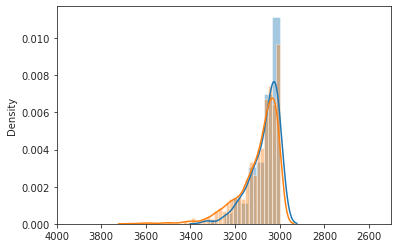

Root age ugam lg posterior (blue) vs prior (red)


In [136]:
sns.distplot(ugam_all_euk_post_ages['414']) #BLUE
sns.distplot(ugam_all_euk_prior_ages['414']) # RED
plt.xlim(4000,2500)
plt.show() 
print('Root age ugam lg posterior (blue) vs prior (red)')

In [52]:
### LOAD Data: all models for All calibrations set (Root, Euk and Cyano)

In [53]:
sat_rootcal_all_euk_Cyano2_ugam_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_all_euk_Cyano2_post.1_sample.datedist')

In [54]:
sat_rootcal_all_euk_Cyano2_ugam_BD_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_all_euk_Cyano2_ugam_BD_post.1_sample.datedist')

In [55]:
sat_rootcal_all_euk_Cyano2_CIR_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_all_euk_Cyano2_CIR_post.1_sample.datedist')

In [56]:
sat_rootcal_all_euk_Cyano2_CIR_BD_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_all_euk_Cyano2_CIR_BD_post.1_sample.datedist')

In [57]:
sat_rootcal_all_euk_Cyano2_LN_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_all_euk_Cyano2_LN_post.1_sample.datedist')

In [58]:
sat_rootcal_all_euk_Cyano2_LN_BD_post = LoadTrees ('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_all_euk_Cyano2_LN_BD_post.1_sample.datedist')

In [59]:
C_all_cals_UGAM_post_ages = getAges(sat_rootcal_all_euk_Cyano2_ugam_post,'sat_rootcal_all_euk_Cyano2_ugam_post')

Length of Datedist 100


In [60]:
C_all_cals_UGAM_BD_post_ages = getAges(sat_rootcal_all_euk_Cyano2_ugam_BD_post,'sat_rootcal_all_euk_Cyano2_ugam_BD_post')

Length of Datedist 100


In [61]:
C_all_cals_CIR_post_ages = getAges(sat_rootcal_all_euk_Cyano2_CIR_post,'sat_rootcal_all_euk_Cyano2_CIR_post')

Length of Datedist 100


In [62]:
C_all_cals_CIR_BD_post_ages = getAges(sat_rootcal_all_euk_Cyano2_CIR_BD_post,'sat_rootcal_all_euk_Cyano2_CIR_BD_post')

Length of Datedist 100


In [63]:
C_all_cals_LN_post_ages = getAges(sat_rootcal_all_euk_Cyano2_LN_post,'sat_rootcal_all_euk_Cyano2_LN_post')

Length of Datedist 100


In [64]:
C_all_cals_LN_BD_post_ages = getAges(sat_rootcal_all_euk_Cyano2_LN_BD_post,'sat_rootcal_all_euk_Cyano2_LN_BD_post')

Length of Datedist 102


In [65]:
# Demo plot of all models for crown age

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

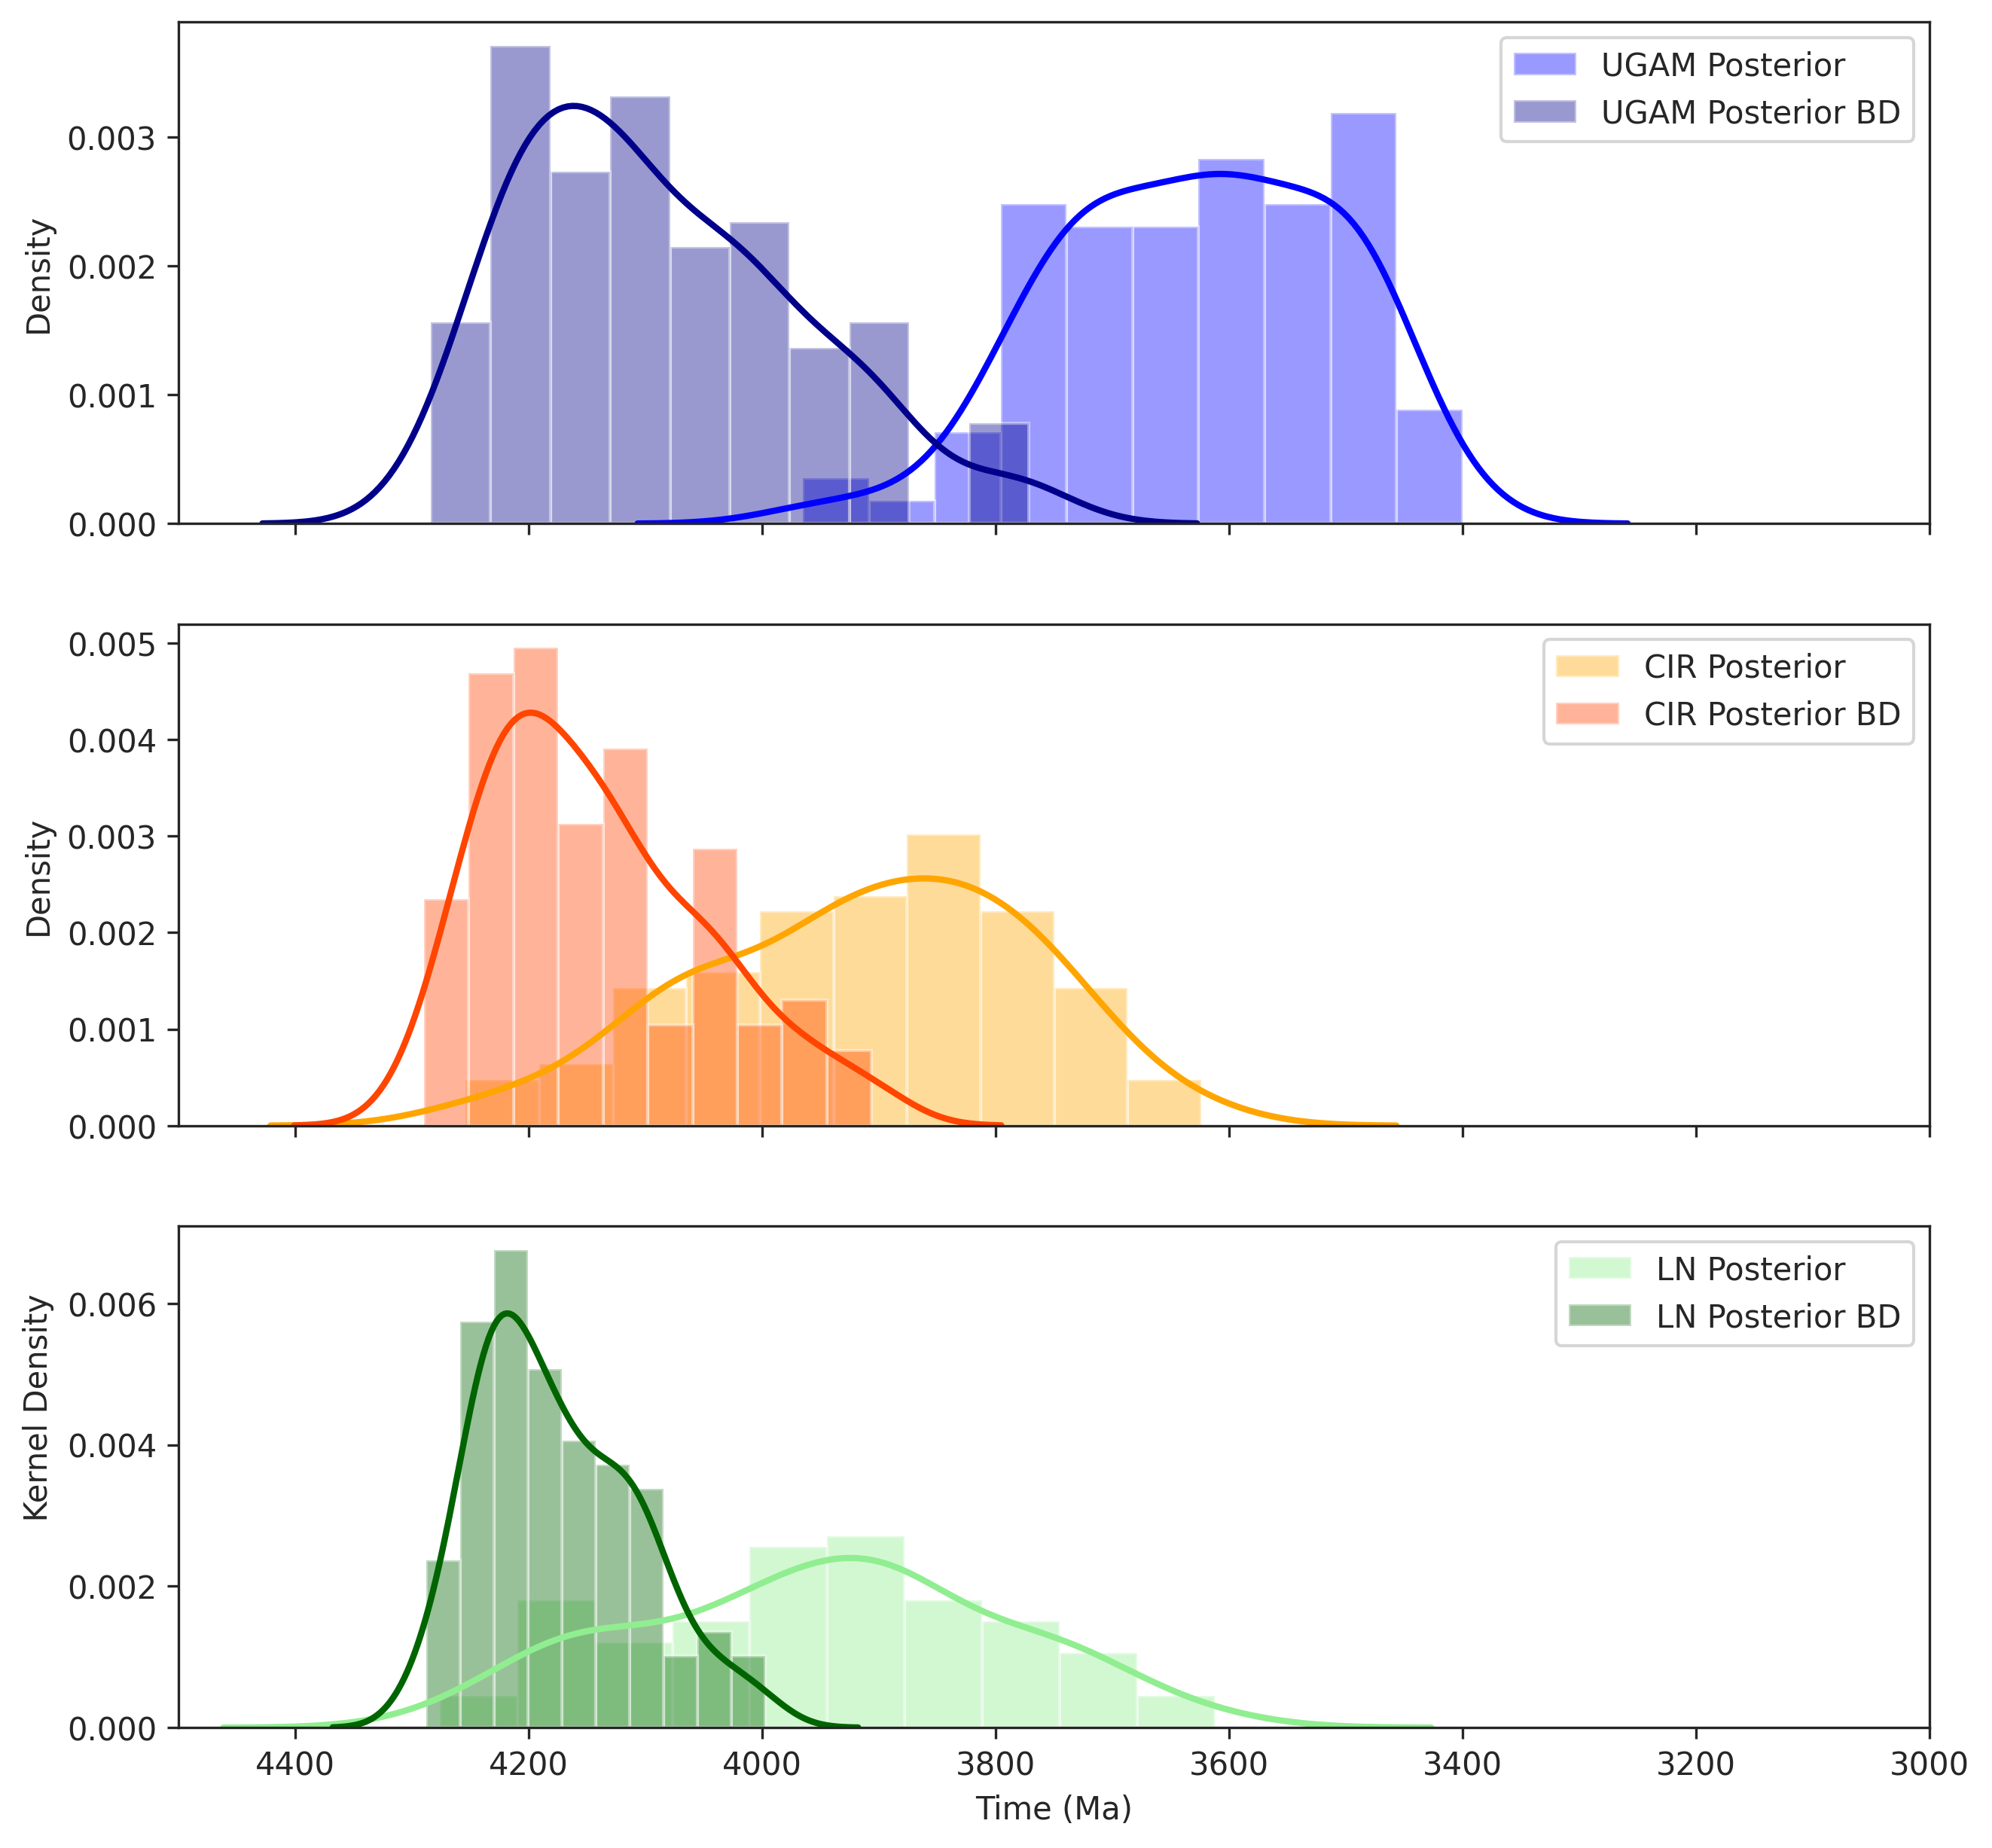

Sat Crown Age All Calibrations and All Models x Branch Rate Processes


In [88]:
sns.set_style('ticks')
kwargs = dict(hist_kws={'alpha':.4},kde_kws={'linewidth':2})
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True,sharey=False,dpi=300) #try 8 x 6 instead of 10x6
plt.xlim(4500,3000)
sns.distplot(C_all_cals_UGAM_post_ages['427'], label="UGAM Posterior",bins=10,ax=axes[0],color="blue", **kwargs)
sns.distplot(C_all_cals_UGAM_BD_post_ages['427'], label="UGAM Posterior BD",bins=10,ax=axes[0],color="darkblue", **kwargs)
axes[0].legend()
sns.distplot(C_all_cals_CIR_post_ages['427'], label="CIR Posterior",bins=10,ax=axes[1],color="orange", **kwargs)
sns.distplot(C_all_cals_CIR_BD_post_ages['427'], label="CIR Posterior BD",bins=10,ax=axes[1],color="orangered", **kwargs)
axes[1].legend()
sns.distplot(C_all_cals_LN_post_ages['427'], label="LN Posterior",bins=10,ax=axes[2],color="lightgreen", **kwargs)
sns.distplot(C_all_cals_LN_BD_post_ages['427'], label="LN Posterior BD",bins=10,ax=axes[2],color="darkgreen", **kwargs)
axes[2].legend()
axes[2].set_ylabel("              Kernel Density")
axes[2].get_xaxis().set_visible(True)
axes[2].set_xlabel("Time (Ma)")
plt.show()
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_AllCalsByAllModels.svg", format="svg")
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_AllCalsByAllModels.png", format="png")
print('Sat Crown Age All Calibrations and All Models x Branch Rate Processes')

In [89]:
### Final Plot

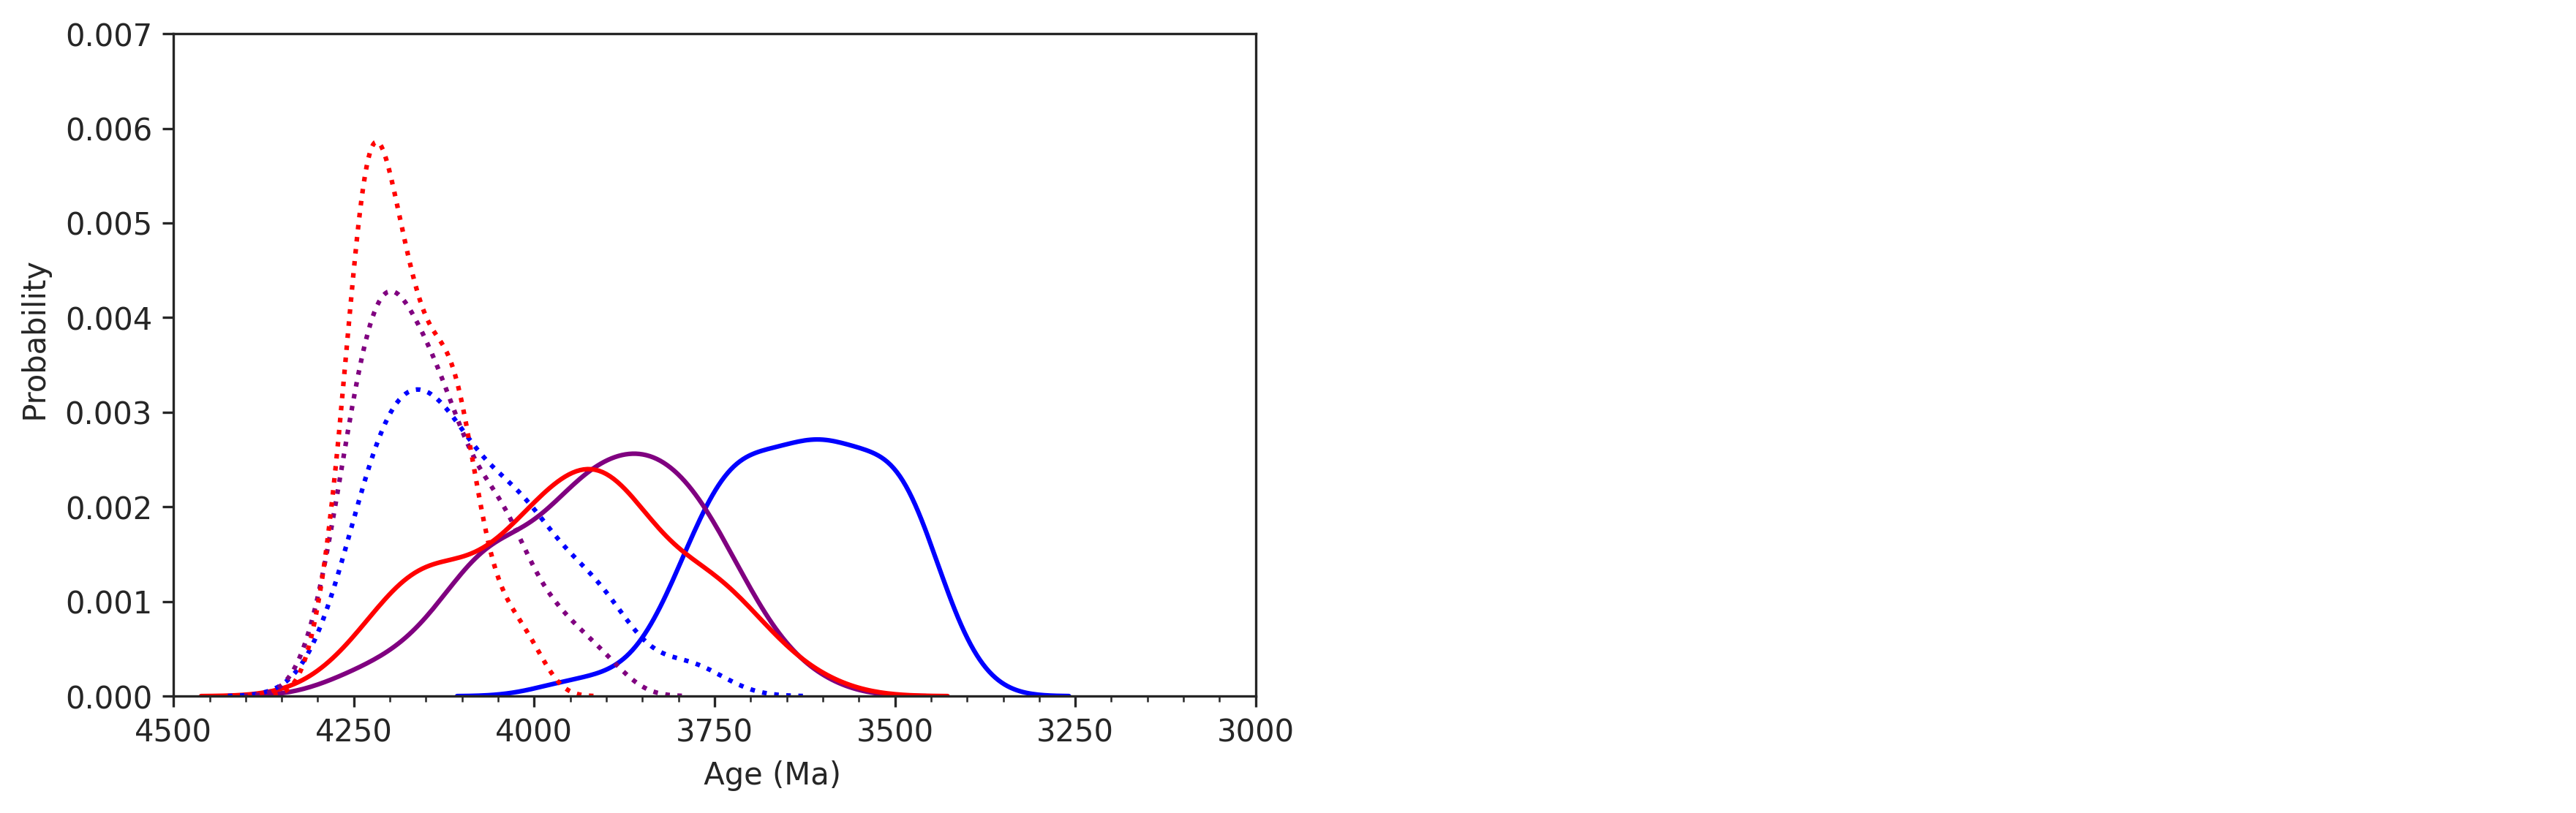

In [90]:
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(C_all_cals_UGAM_post_ages['427'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(C_all_cals_CIR_post_ages['427'][0],label="Node ",
                    ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(C_all_cals_LN_post_ages['427'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)

axes[0]=sns.kdeplot(C_all_cals_UGAM_BD_post_ages['427'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(C_all_cals_CIR_BD_post_ages['427'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(C_all_cals_LN_BD_post_ages['427'][0],label="Node ",linestyle=':',
                    ax=axes[0],color="red", **kwargs)

#Corrected line style so Blue dashed is the prior and Red solid is posterior

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.007])
### X-limits 
axes[0].set_xlim([4500,3000])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
#axes[0].title.set_text('Clock_sat_STEM_AGE_eukaryotic_and_Cyano_cal_UGAM_BLUE_CIR_PURPLE_LN_RED')
fig.savefig('Clock_sat_CrownAge_eukaryotic_and_Cyano_cal_UGAM_BLUE_CIR_PURPLE_LN_RED'+'.svg',format='svg')
fig.savefig('Clock_sat_CrownAge_eukaryotic_and_Cyano_cal_UGAM_BLUE_CIR_PURPLE_LN_RED'+'.png',format='png')

In [91]:
### Load CIR posterior noBD data for different calibrations Root only, Euk only, Cyano only

In [92]:
sat_rootcal_CIR_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_CIR_post.1_sample.datedist')

In [93]:
sat_rootcal_all_euk_CIR_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_CIR_post.1_sample.datedist')

In [94]:
sat_rootcal_Cyano2_CIR_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_Cyano2_only_CIR_post.1_sample.datedist')

In [95]:
C_root_cal_CIR_post = getAges(sat_rootcal_CIR_post,'sat_rootcal_CIR_post')

Length of Datedist 115


In [96]:
C_euk_cal_CIR_post = getAges(sat_rootcal_all_euk_CIR_post,'sat_rootcal_all_euk_CIR_post')

Length of Datedist 101


In [97]:
C_cyano_cal_CIR_post = getAges(sat_rootcal_Cyano2_CIR_post,'sat_rootcal_Cyano2_CIR_post')

Length of Datedist 100


In [98]:
# Plot cross calibration plot for CIR no BD model

root_only_blue_euk_only_green_cyano_only_red_all_cals_purple


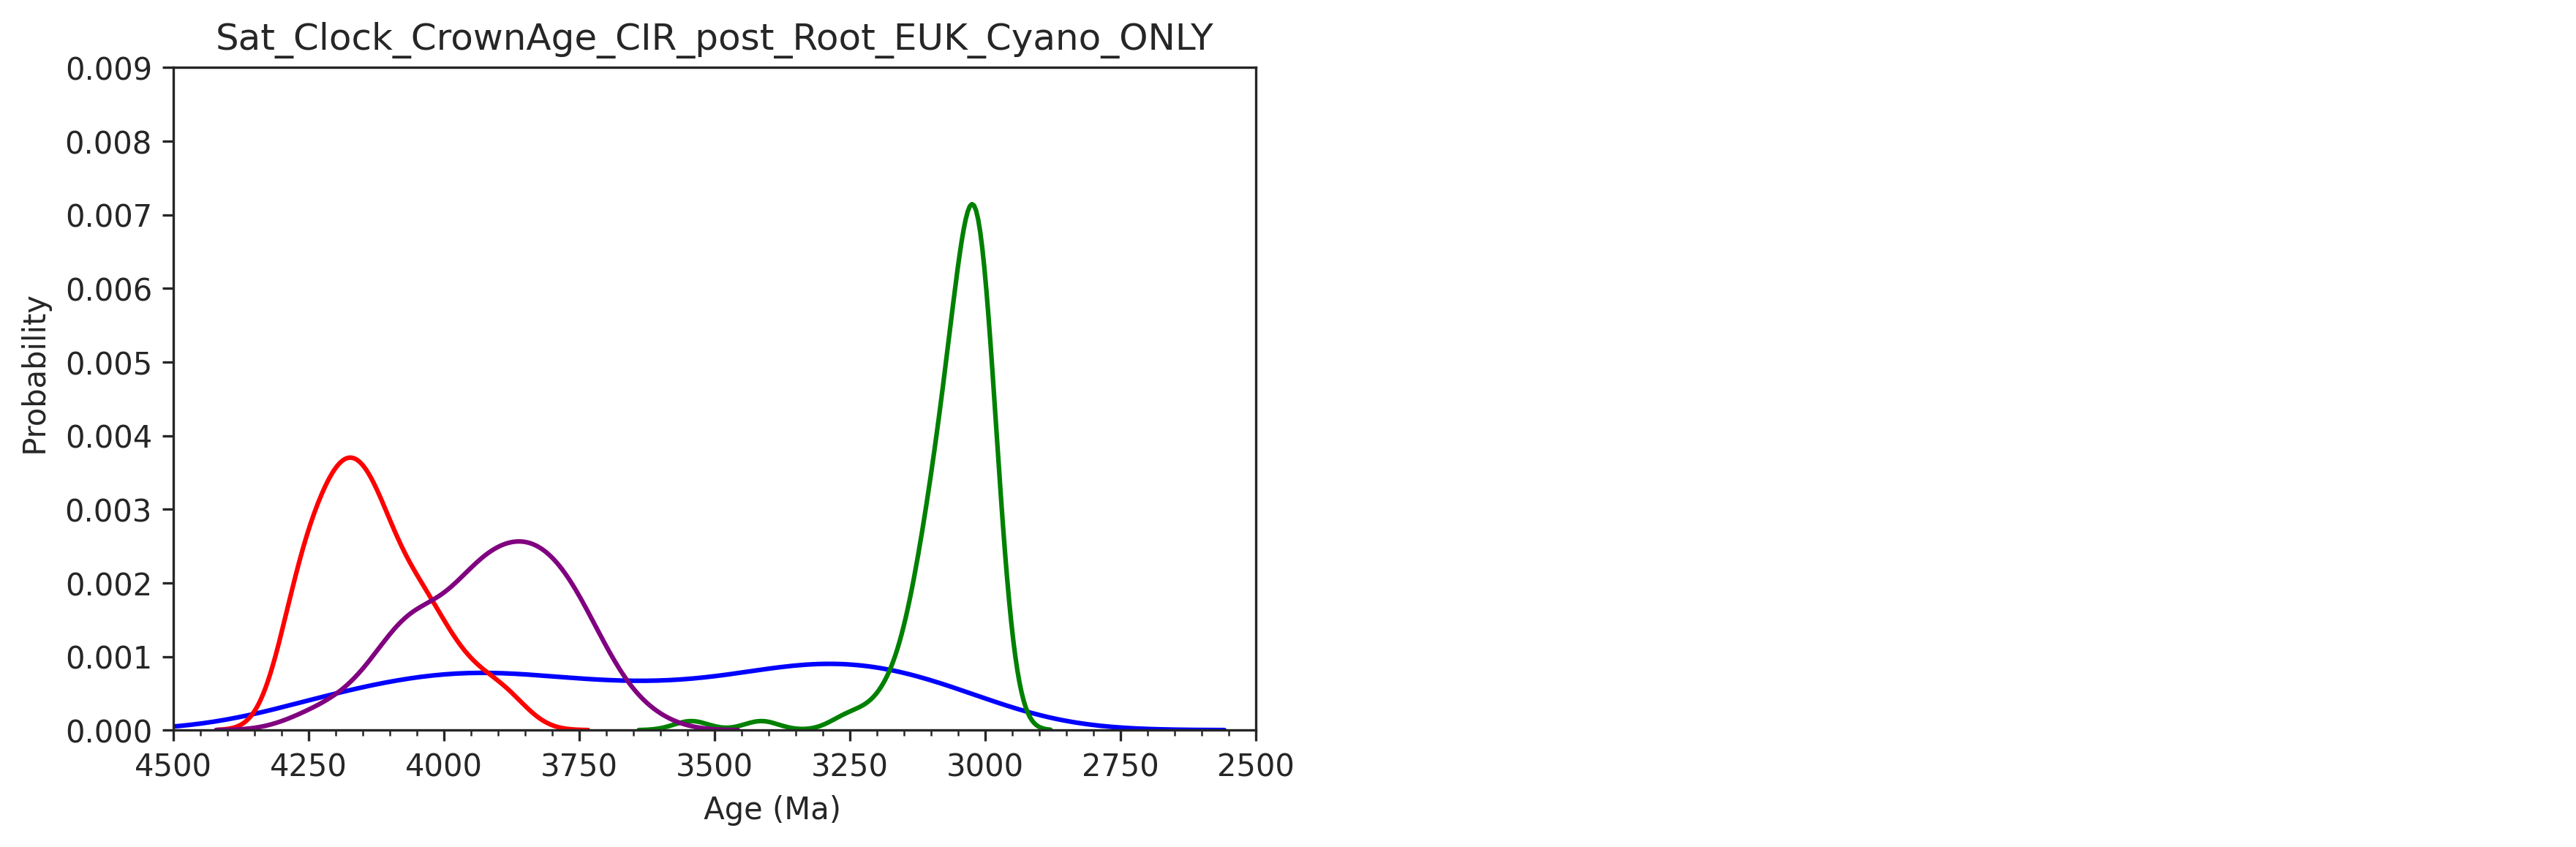

In [133]:
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(C_root_cal_CIR_post['427'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(C_euk_cal_CIR_post['427'][0],label="Node ",
                    ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(C_cyano_cal_CIR_post['427'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(C_all_cals_CIR_post_ages['427'][0],label="Node ",
                    ax=axes[0],color="purple", **kwargs)


#Corrected line style so Blue dashed is the prior and Red solid is posterior

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.009])
### X-limits 
axes[0].set_xlim([4500,2500])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('Sat_Clock_CrownAge_CIR_post_Root_EUK_Cyano_ONLY')
fig.savefig('Sat_Clock_CrownAge_CIR_post_Root_EUK_Cyano_ONLY'+'.svg',format='svg')
fig.savefig('Sat_Clock_CrownAge_CIR_post_Root_EUK_Cyano_ONLY'+'.png',format='png')
print("root_only_blue_euk_only_green_cyano_only_red_all_cals_purple")

In [ ]:
### LOAD Data: all models for EUK ONLY calibrations set (Root, Euk)

In [131]:
C_euk_only_ugam_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_post.1_sample.datedist')

In [132]:
C_euk_only_ugam_post_ages = getAges(C_euk_only_ugam_post,'C_euk_only_ugam_post')

Length of Datedist 100


In [137]:
C_euk_only_ugam_BD_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_ugam_BD_post.1_sample.datedist')

In [138]:
C_euk_only_ugam_BD_post_ages = getAges(C_euk_only_ugam_BD_post,'C_euk_only_ugam_BD_post')

Length of Datedist 104


In [139]:
C_euk_only_CIR_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_CIR_post.1_sample.datedist')

In [140]:
C_euk_only_CIR_post_ages = getAges(C_euk_only_CIR_post,'C_euk_only_CIR_post')

Length of Datedist 101


In [141]:
C_euk_only_CIR_BD_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_CIR_BD_post.1_sample.datedist')

In [142]:
C_euk_only_CIR_BD_post_ages = getAges(C_euk_only_CIR_BD_post,'C_euk_only_CIR_BD_post')

Length of Datedist 100


In [143]:
C_euk_only_LN_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_LN_post.1_sample.datedist')

In [144]:
C_euk_only_LN_post_ages = getAges(C_euk_only_LN_post,'C_euk_only_LN_post')

Length of Datedist 100


In [145]:
C_euk_only_LN_BD_post = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_all_euk_LN_BD_post.1_sample.datedist')

In [146]:
C_euk_only_LN_BD_post_ages = getAges(C_euk_only_LN_post,'C_euk_only_LN_BD_post')

Length of Datedist 100


In [ ]:
####

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

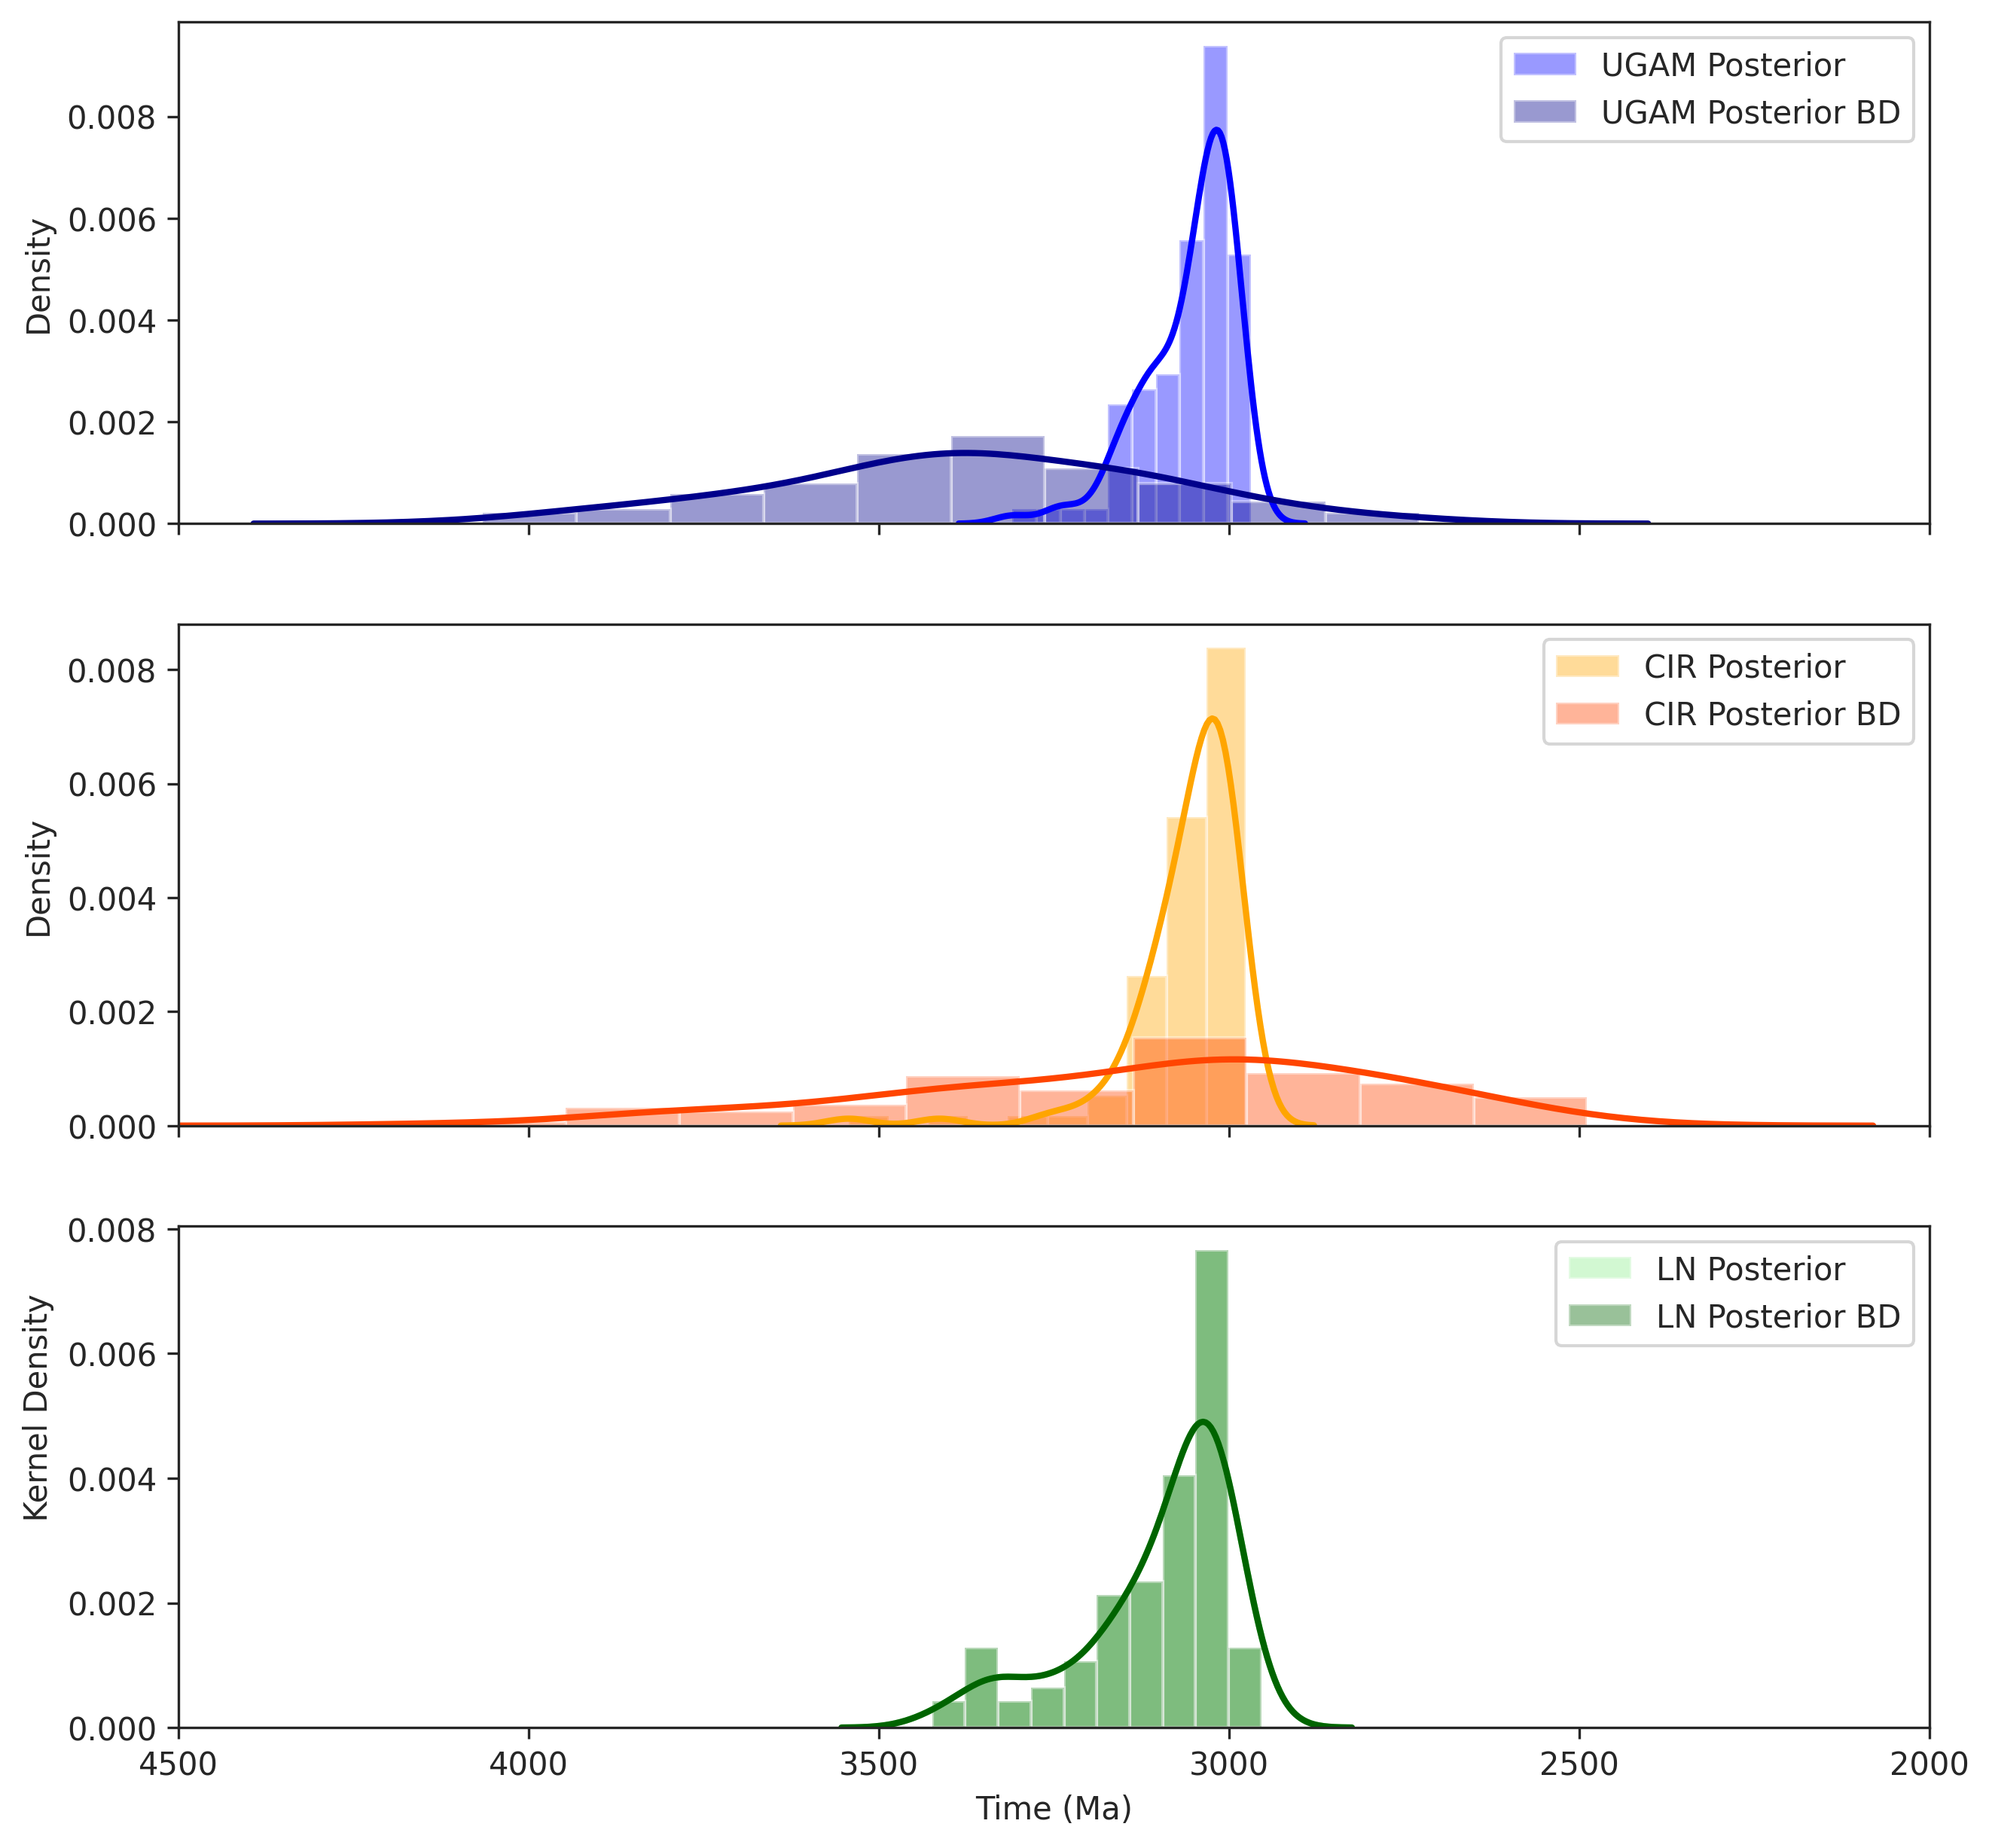

Sat Crown Age Euk Calibrations and All Models x Branch Rate Processes


In [148]:
sns.set_style('ticks')
kwargs = dict(hist_kws={'alpha':.4},kde_kws={'linewidth':2})
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True,sharey=False,dpi=300) #try 8 x 6 instead of 10x6
plt.xlim(4500,2000)
sns.distplot(C_euk_only_ugam_post_ages['427'], label="UGAM Posterior",bins=10,ax=axes[0],color="blue", **kwargs)
sns.distplot(C_euk_only_ugam_BD_post_ages['427'], label="UGAM Posterior BD",bins=10,ax=axes[0],color="darkblue", **kwargs)
axes[0].legend()
sns.distplot(C_euk_only_CIR_post_ages['427'], label="CIR Posterior",bins=10,ax=axes[1],color="orange", **kwargs)
sns.distplot(C_euk_only_CIR_BD_post_ages['427'], label="CIR Posterior BD",bins=10,ax=axes[1],color="orangered", **kwargs)
axes[1].legend()
sns.distplot(C_euk_only_LN_post_ages['427'], label="LN Posterior",bins=10,ax=axes[2],color="lightgreen", **kwargs)
sns.distplot(C_euk_only_LN_BD_post_ages['427'], label="LN Posterior BD",bins=10,ax=axes[2],color="darkgreen", **kwargs)
axes[2].legend()
axes[2].set_ylabel("              Kernel Density")
axes[2].get_xaxis().set_visible(True)
axes[2].set_xlabel("Time (Ma)")
plt.show()
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_EukCalsByAllModels.svg", format="svg")
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_EukCalsByAllModels.png", format="png")
print('Sat Crown Age Euk Calibrations and All Models x Branch Rate Processes')

In [ ]:
### LOAD Data: all models for Cyano ONLY calibrations set (Root, Cyano2)

In [ ]:
C_Cyano_only_ugam_post = LoadTrees('.datedist')

In [ ]:
C_Cyano_only_ugam_post_ages = getAges(C_Cyano_only_ugam_post,'C_Cyano_only_ugam_post')

In [149]:
C_Cyano_only_ugam_BD_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_Cyano2_only_UGAM_BD_post.1_sample.datedist')

In [150]:
C_Cyano_only_ugam_BD_post_ages = getAges(C_Cyano_only_ugam_BD_post,'C_Cyano_only_ugam_BD_post')

Length of Datedist 100


In [151]:
C_Cyano_only_CIR_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_Cyano2_only_CIR_post.1_sample.datedist')

In [152]:
C_Cyano_only_CIR_post_ages = getAges(C_Cyano_only_CIR_post,'C_Cyano_only_ugam_CIR_post')

Length of Datedist 100


In [153]:
C_Cyano_only_CIR_BD_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_Cyano2_only_CIR_BD_post.1_sample.datedist')

In [154]:
C_Cyano_only_CIR_BD_post_ages = getAges(C_Cyano_only_CIR_BD_post,'C_Cyano_only_ugam_CIR_BD_post')

Length of Datedist 100


In [155]:
C_Cyano_only_LN_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_Cyano2_only_LN_post.1_sample.datedist')

In [156]:
C_Cyano_only_LN_post_ages = getAges(C_Cyano_only_LN_post,'C_Cyano_only_ugam_LN_post')

Length of Datedist 100


In [157]:
C_Cyano_only_LN_BD_post = LoadTrees('sat_sub414_rmgaps_06122024_ugam_lg_rootcal_Cyano2_only_LN_BD_post.1_sample.datedist')

In [158]:
C_Cyano_only_LN_BD_post_ages = getAges(C_Cyano_only_LN_BD_post,'C_Cyano_only_ugam_LN_BD_post')

Length of Datedist 100


/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

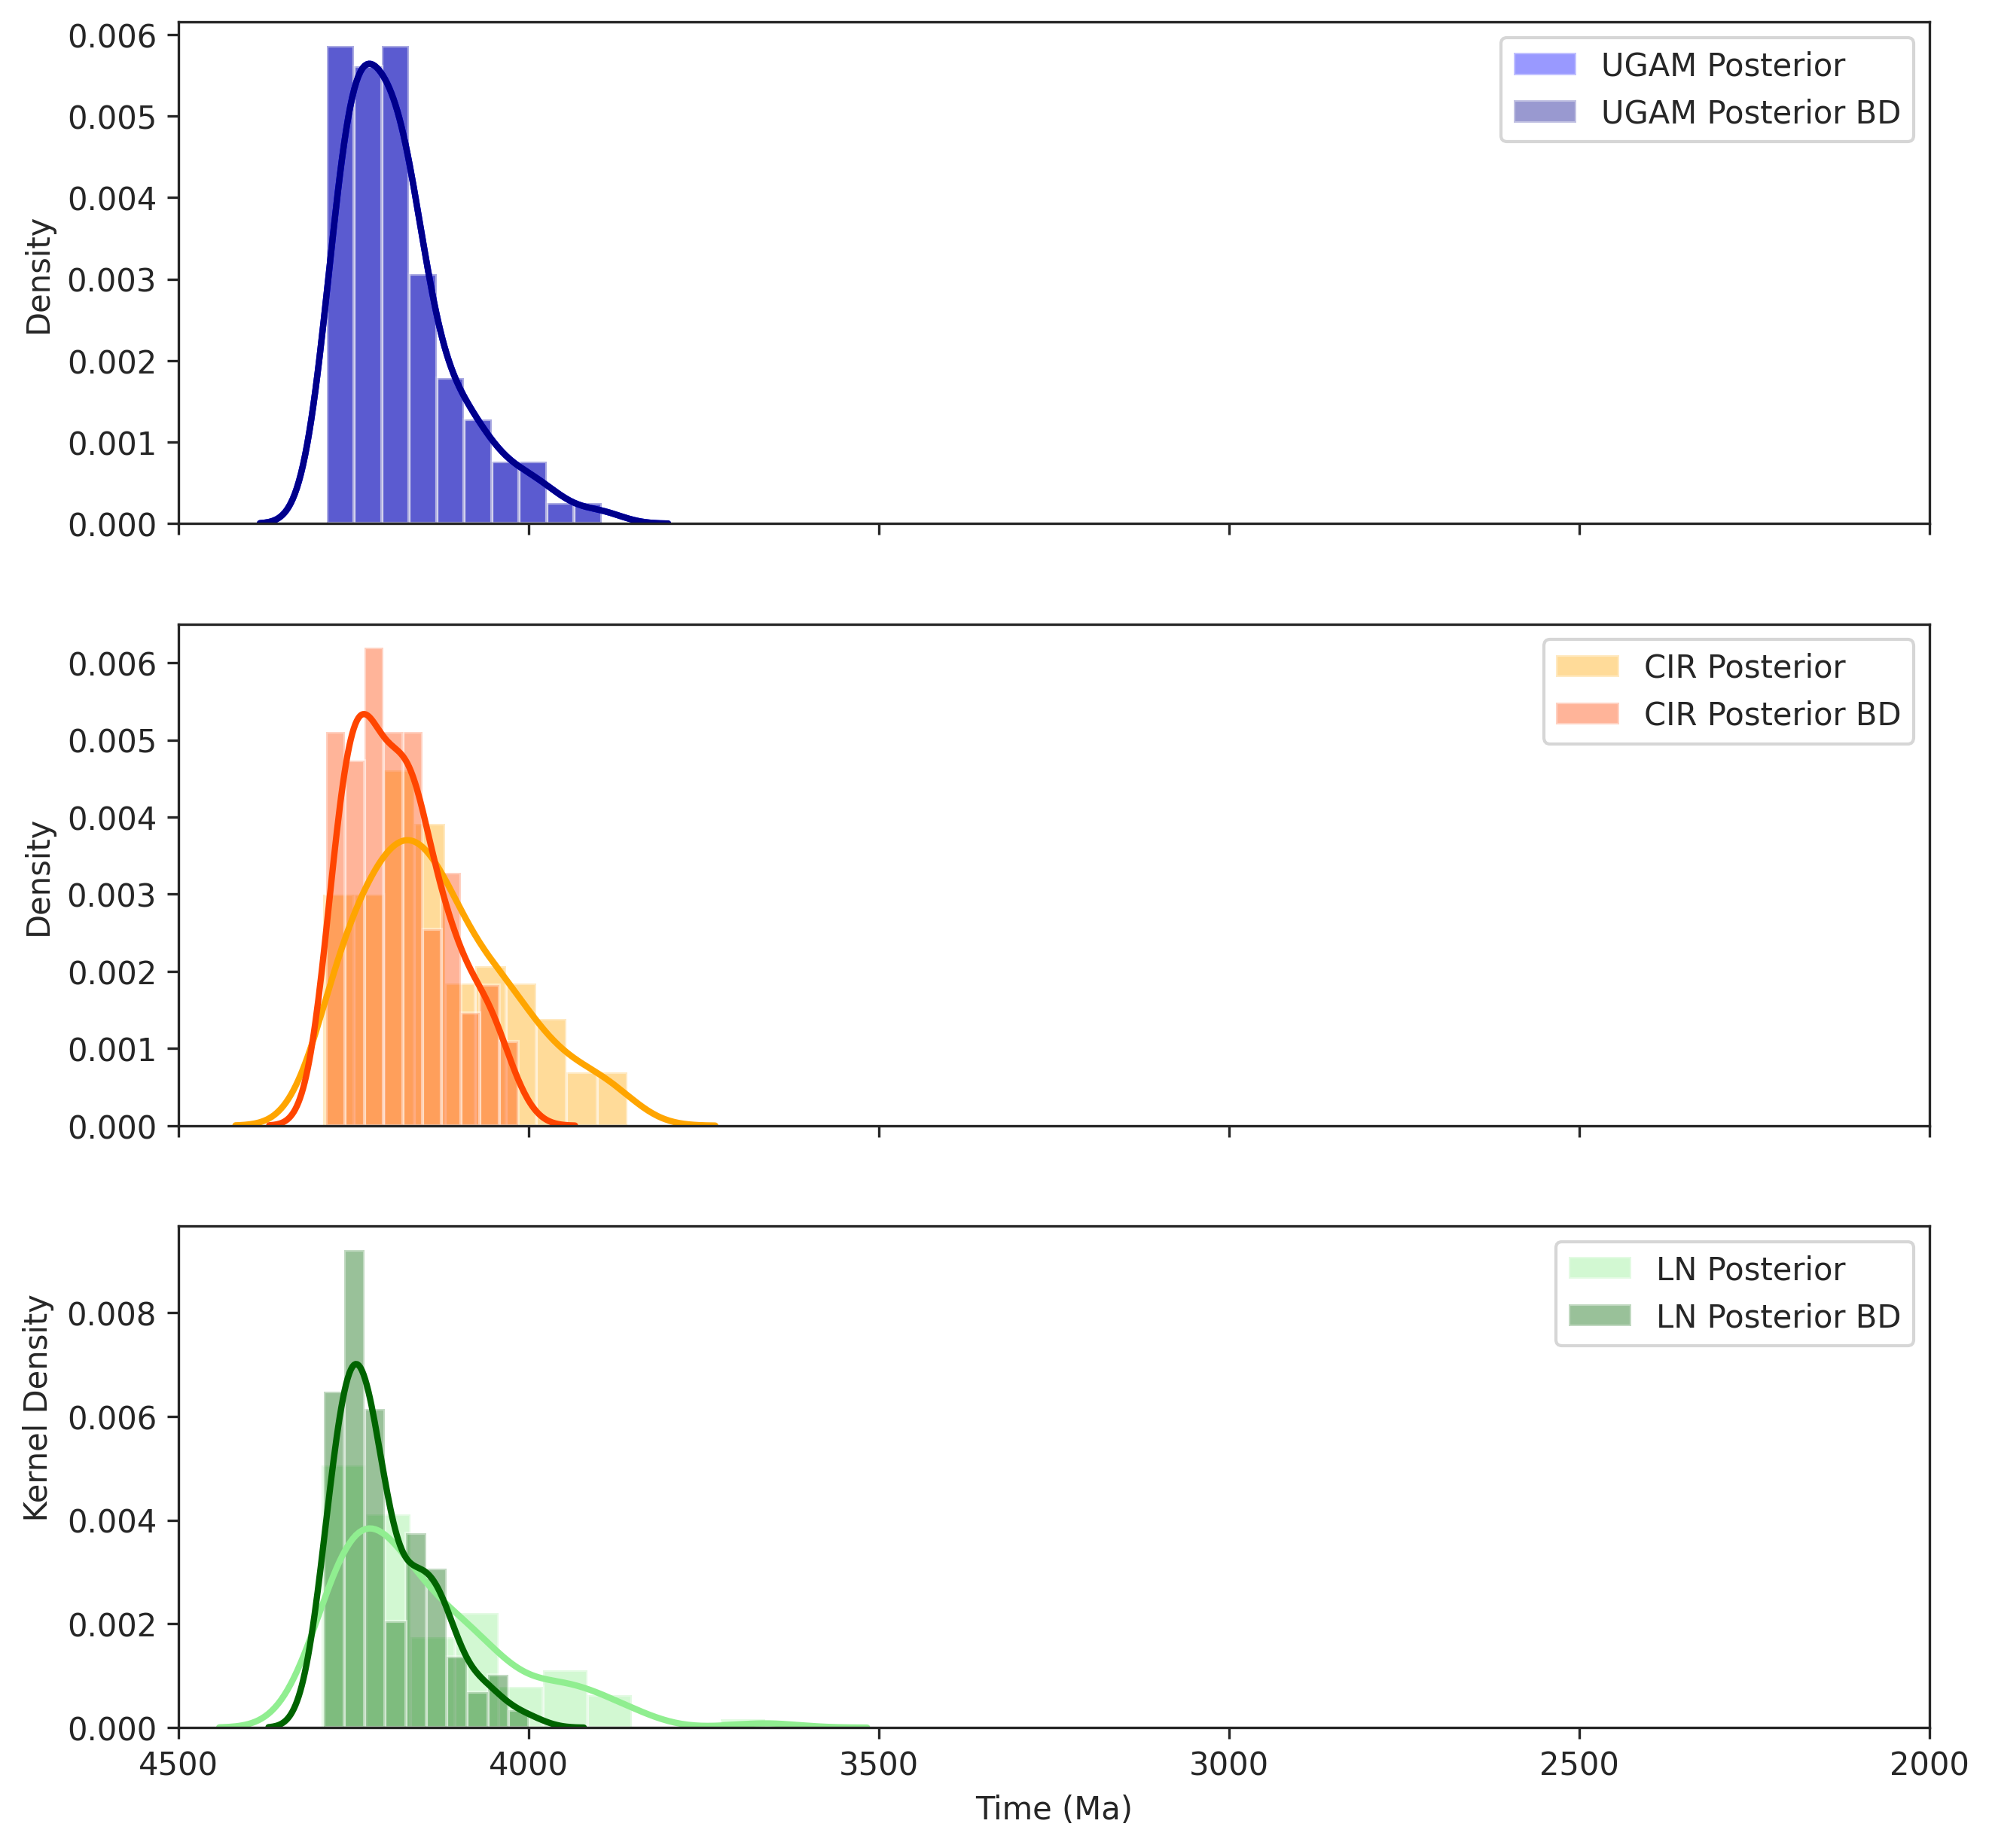

Sat Crown Age Cyano Calibrations and All Models x Branch Rate Processes


In [160]:
sns.set_style('ticks')
kwargs = dict(hist_kws={'alpha':.4},kde_kws={'linewidth':2})
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True,sharey=False,dpi=300) #try 8 x 6 instead of 10x6
plt.xlim(4500,2000)
sns.distplot(C_Cyano_only_ugam_BD_post_ages['427'], label="UGAM Posterior",bins=10,ax=axes[0],color="blue", **kwargs)
sns.distplot(C_Cyano_only_ugam_BD_post_ages['427'], label="UGAM Posterior BD",bins=10,ax=axes[0],color="darkblue", **kwargs)
axes[0].legend()
sns.distplot(C_Cyano_only_CIR_post_ages['427'], label="CIR Posterior",bins=10,ax=axes[1],color="orange", **kwargs)
sns.distplot(C_Cyano_only_CIR_BD_post_ages['427'], label="CIR Posterior BD",bins=10,ax=axes[1],color="orangered", **kwargs)
axes[1].legend()
sns.distplot(C_Cyano_only_LN_post_ages['427'], label="LN Posterior",bins=10,ax=axes[2],color="lightgreen", **kwargs)
sns.distplot(C_Cyano_only_LN_BD_post_ages['427'], label="LN Posterior BD",bins=10,ax=axes[2],color="darkgreen", **kwargs)
axes[2].legend()
axes[2].set_ylabel("              Kernel Density")
axes[2].get_xaxis().set_visible(True)
axes[2].set_xlabel("Time (Ma)")
plt.show()
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_Cyano2CalsByAllModels.svg", format="svg")
fig.savefig("Sat_CrownAge_NodeAgeEstimate427_Cyano2CalsByAllModels.png", format="png")
print('Sat Crown Age Cyano Calibrations and All Models x Branch Rate Processes')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

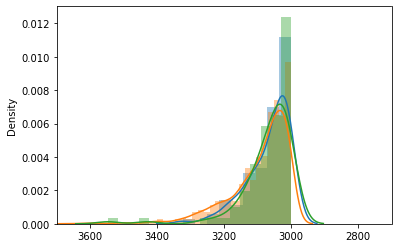

ugam lg posterior (blue) vs prior (red)


In [89]:
sns.distplot(ugam_all_euk_post_ages['414'])
sns.distplot(ugam_all_euk_prior_ages['414'])
#sns.distplot(ugam_lg_rootcal_broad_ages['414'])
#sns.distplot(ugam_all_euk_Cyano_post_ages['414'])
#sns.distplot(ugam_all_euk_ugam_BD_post_ages['414'])
sns.distplot(ugam_all_euk_CIR_post_ages['414'])
plt.xlim(3700,2700)
plt.show() 
print('ugam lg posterior (blue) vs prior (red)')

In [ ]:
#sns.distplot(ugam_all_euk_post_ages['414'])
#sns.distplot(ugam_all_euk_prior_ages['414'])
sns.distplot(ugam_lg_rootcal_broad_ages['414'])
sns.distplot(ugam_all_euk_Cyano_post_ages['414'])
#sns.distplot(ugam_all_euk_ugam_BD_post_ages['414'])
#sns.distplot(ugam_all_euk_CIR_post_ages['414'])
plt.xlim(4500,2500)
plt.show() 
print('ugam lg posterior (blue) vs prior (red)')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


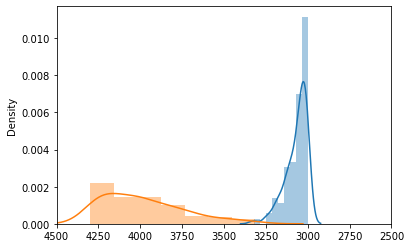

ugam lg posterior (blue) vs prior (red)


In [46]:
sns.distplot(ugam_all_euk_post_ages['414'])
#sns.distplot(ugam_all_euk_prior_ages['414'])
#sns.distplot(ugam_lg_rootcal_broad_ages['414'])
#sns.distplot(ugam_all_euk_Cyano_post_ages['414'])
sns.distplot(ugam_all_euk_ugam_BD_post_ages['414'])
#sns.distplot(ugam_all_euk_CIR_post_ages['414'])
plt.xlim(4500,2500)
plt.show() 
print('ugam lg posterior (blue) vs prior (red)')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

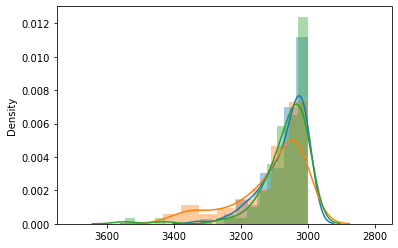

ugam lg posterior (blue) vs prior (red)


In [108]:
sns.distplot(ugam_all_euk_post_ages['414'])
#sns.distplot(ugam_all_euk_prior_ages['414'])
#sns.distplot(ugam_lg_rootcal_broad_ages['414'])
#sns.distplot(ugam_all_euk_Cyano_post_ages['414'])
sns.distplot(ugam_all_euk_LN_post_ages['414'])
sns.distplot(ugam_all_euk_CIR_post_ages['414'])
plt.xlim(3750,2750)
plt.show() 
print('ugam lg posterior (blue) vs prior (red)')

In [29]:
ugam_lg_rootcal_broad = LoadTrees('sat_sub414_rmgaps_05082024_ugam_lg_rootcal_broad_post.1_sample.datedist')

In [30]:
ugam_lg_rootcal_broad_ages = getAges(ugam_lg_rootcal_broad,'ugam_lg_rootcal_broad')

Length of Datedist 100


In [ ]:
ugam_lg_rootcal_post = LoadTrees('rbcL_new_04212024_ugam_lg_rootcal_post_sample.datedist')

In [ ]:
ugam_lg_rootcal_post_ages = getAges(ugam_lg_rootcal_post,'ugam_lg_rootcal_post')

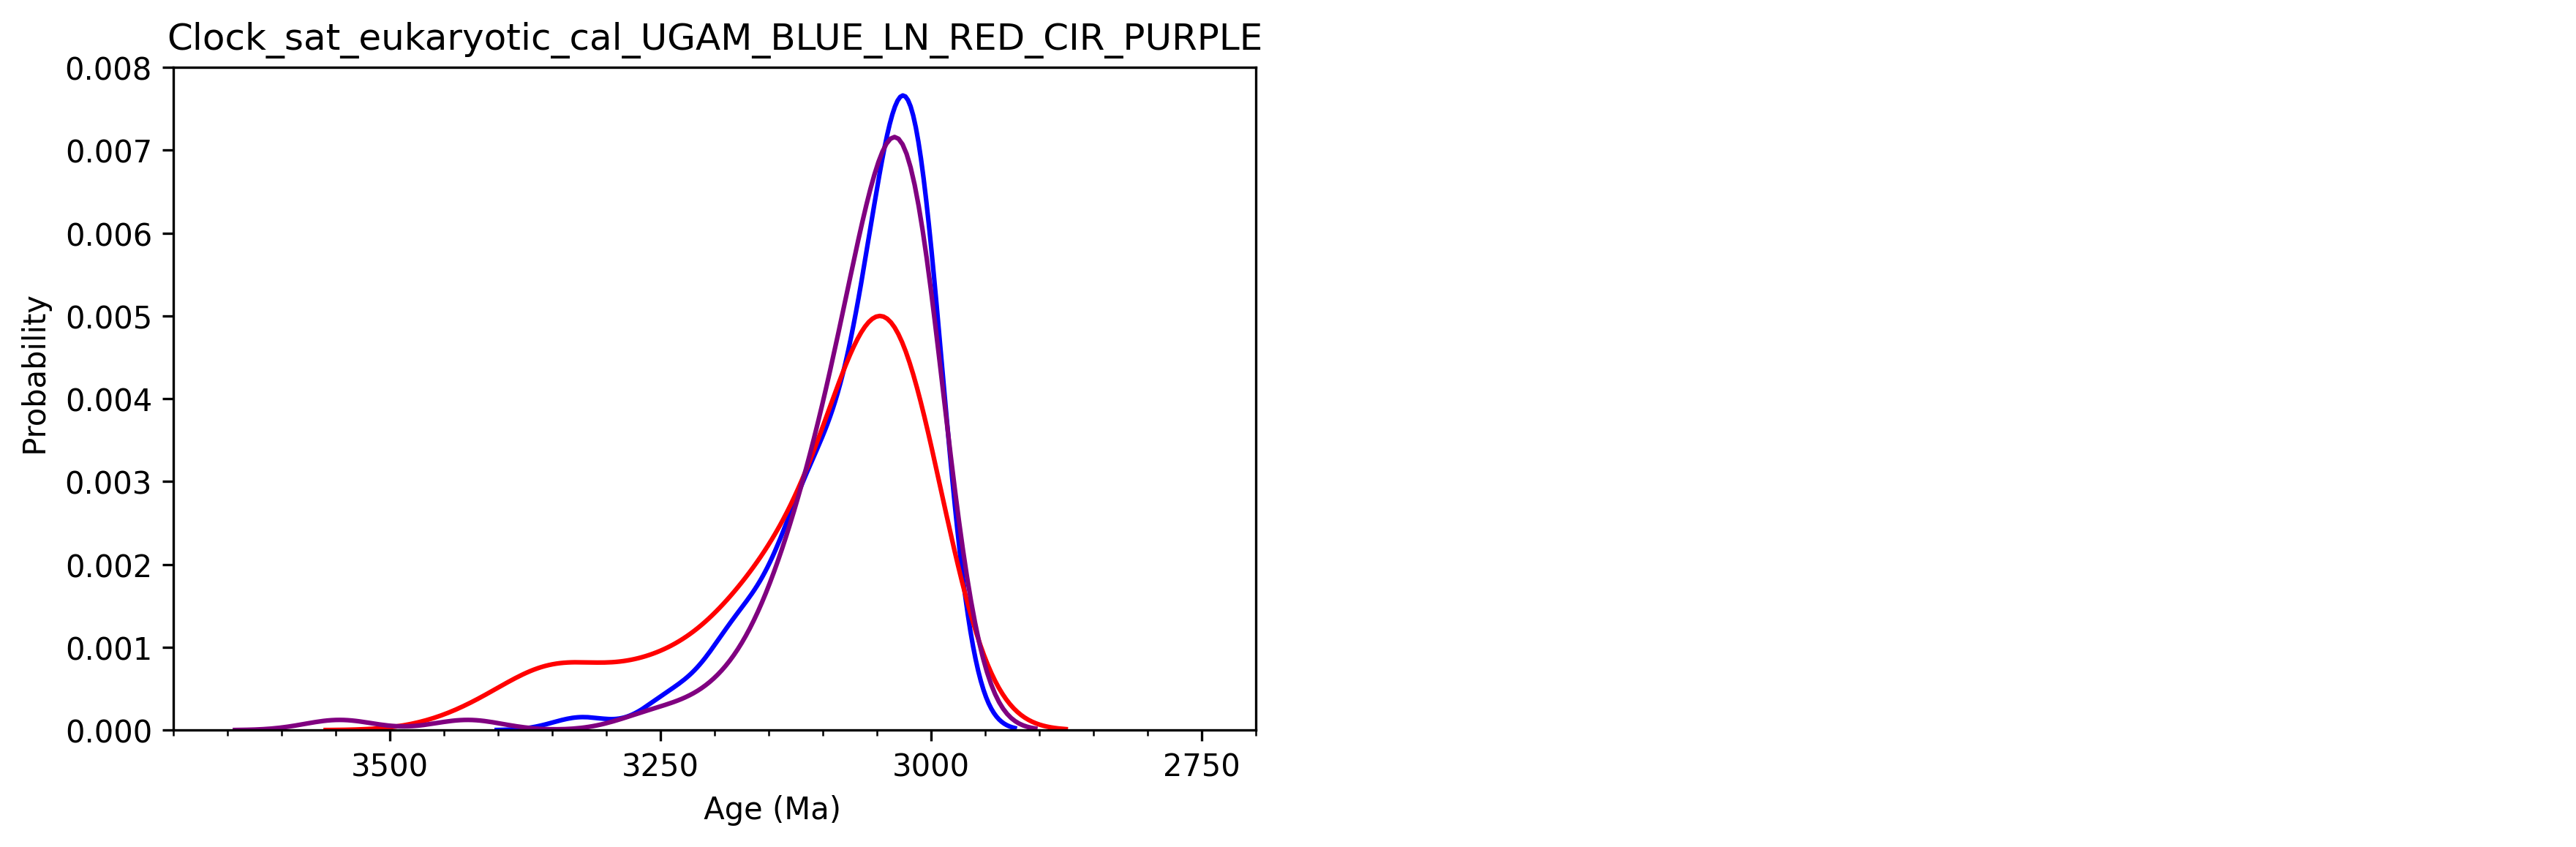

In [118]:
kwargs = {"linewidth" : "1.5"}
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0]=sns.kdeplot(ugam_all_euk_post_ages['414'][0],label="Node ",
                    ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(ugam_all_euk_LN_post_ages['414'][0],label="Node ",
                    ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(ugam_all_euk_CIR_post_ages['414'][0],label="Node ",
                    ax=axes[0],color="purple", **kwargs)

#Corrected line style so Blue dashed is the prior and Red solid is posterior

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ma) ")

### Y-limits 
axes[0].set_ylim([0,0.008])
### X-limits 
axes[0].set_xlim([3700,2700])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[1].axis('off')
axes[0].title.set_text('Clock_sat_eukaryotic_cal_UGAM_BLUE_LN_RED_CIR_PURPLE')
#fig.savefig('Nitrilase_cir_610_wcals_NodeAge_468_10_16_22'+'.svg',format='svg')
#fig.savefig('Nitrilase_cir_610_wcals_NodeAge_468_10_16_22'+'.png',format='png')